In [5]:
import matplotlib.pyplot as plt
import scipy.io
import tensorflow as tf
import time
import numpy as np
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop
from models.discriminator import get_discriminator
from models.generator import get_generator
from models.encoder import get_encoder
from tqdm import tqdm
from joblib import load
import os
from pathlib import Path
from os import path
from utils.wasserstein_dist import wasserstein_dist
from utils.loaddata import generate_boundary_data, generate_interior_data, get_data
import seaborn as sns

The Burgers equation:
$$
\begin{split}
    & u_t + u u_{x} - \nu u_{xx} = 0, \hspace{1em} \text{(P.D.E.)}, \hspace{1em} (x,t) \in [-1,1] \times [0,1]\\
    & u(x,t=0) = - \sin(\pi x), \hspace{1em} \text{(I.C.)}\\
    & u(x=-1,t) = u(x=1,t)=0, \hspace{1em} \text{(B.C.)}
\end{split}
$$
where viscosity parameter is chosen as $\nu = \frac{0.01}{\pi}$. Here we adopt a more complicated non-Gaussian and spatially dependent random initial conditions, i.e.,
$$
    \begin{split}
        & u(x,t=0)= \sin (\pi (x+\delta_1)) + \delta_1, \hspace{1em} \delta_1 = \frac{\epsilon_1}{\exp(3|x|)}, \hspace{1em} \epsilon_1 \sim \mathcal{N}(0,\sigma_1), \hspace{1em} \text{(I.C.)}
    \end{split}
$$
with the noise level $\sigma_1=0.1$.

In [6]:
tf.random.set_seed(666666)
np.random.seed(666666)

# Define some hyper-parameters 
noise_level = 0.10
par_pinns = 1 # hyperparameter to balance wgan and pinns regularization term
N_r = 10000 # number of training data for residual (k in my paper)
N_u = 800 # number of training data for uncertain boundary/initial conditions (m=n in my paper)
z_shape = 2 # we adopt 2-dimensional standard normal noise as input for uncertainty quantification
g_depth = 4 # depth of generators (D_g)
g_width = 50 # width of generators (W_g)
d_depth = 3 # depth of discriminators (D_f)
d_width = 50 # width of discriminators
lrg = 1e-4 # learning rate for generators
lrd = 1e-4 # learning rate for discriminators
beta_1 = 0.9
beta_2 = 0.99 # those two beta_s are for Adam optimizor.
bjorck_beta = 0.5 
bjorck_iter = 5
bjorck_order = 2 # hyper-parameters for bjorck orthonomalization iteration
group_size = 2 # groupsize of groupsort neural networks
num_itr = 40000 # maximun number of itertions

In [7]:
class WGAN_PINNs(object):

    def __init__(self,
                 noise_level=0.05,
                 N_r=200,
                 N_u=20,
                 X_mean=0,
                 X_std=1,
                 T_mean=1,
                 T_std=1,
                 par_pinns=1,
                 z_shape=50,
                 out_dim=1,
                 num_itr=50,
                 g_depth=5,
                 g_width=64,
                 d_depth=5,
                 d_width=64,
                 lrg=1e-4,
                 lrd=1e-4,
                 beta_1=0.9,
                 beta_2=0.999,
                 bjorck_beta=0.5,
                 bjorck_iter=5,
                 bjorck_order=2,
                 group_size=2):

        self.noise_level = noise_level
        self.N_r = N_r
        self.N_u = N_u
        self.X_mean = X_mean
        self.X_std = X_std
        self.T_mean = T_mean
        self.T_std = T_std
        self.z_shape = z_shape
        self.out_dim = out_dim
        self.num_itr = num_itr
        self.JacobianX = 1 / self.X_std
        self.JacobianT = 1 / self.T_std
        self.par_pinns = par_pinns
        self.x_shape = 2
        self.k_d = 1
        self.k_g = 5

        self.d_depth = d_depth
        self.d_width = d_width
        self.g_depth = g_depth
        self.g_width = g_width

        # network initialization
        self.G = get_generator(input_shape=(self.z_shape + self.x_shape,), output_shape=self.out_dim, depth=g_depth,
                               width=g_width)
        self.D = get_discriminator(input_shape=(self.out_dim + self.x_shape,), depth=d_depth, width=d_width,
                                   bjorck_beta=bjorck_beta, bjorck_iter=bjorck_iter, bjorck_order=bjorck_order,
                                   group_size=group_size)

        self.G_optimizer = Adam(learning_rate=lrg, beta_1=beta_1, beta_2=beta_2)
        self.D_optimizer = Adam(learning_rate=lrd, beta_1=beta_1, beta_2=beta_2)

        self.Loss = 0.0
    
    # r.h.s. of the pde
    def f(self, X_normalized):
        return 0.0

    def generator_loss(self, fake_output, residual):
        return tf.math.reduce_mean(fake_output) + self.par_pinns * residual

    def discriminator_loss(self, real_output, fake_output):
        return -tf.math.reduce_mean(fake_output) + tf.math.reduce_mean(real_output)
    
    # get residual
    def get_r(self, XT_r, noises):
        X_r = XT_r[:, 0][:, None]
        T_r = XT_r[:, 1][:, None]
        with tf.GradientTape(watch_accessed_variables=False) as pde_tape2:
            pde_tape2.watch(X_r)
            with tf.GradientTape(persistent=True, watch_accessed_variables=False) as pde_tape1:
                pde_tape1.watch([X_r, T_r])
                u = self.G(tf.concat([noises, X_r, T_r], axis=1), training=True)
            u_x = pde_tape1.gradient(u, X_r)
            u_t = pde_tape1.gradient(u, T_r)
            # print(tf.shape(u_x))
        u_xx = pde_tape2.gradient(u_x, X_r)
        f = self.f(X_r)
        r = u_t * self.JacobianT + u * u_x * self.JacobianX - 0.01 / np.pi * u_xx * (self.JacobianX ** 2)
        r2 = r ** 2
        return tf.math.reduce_mean(r2)

    @tf.function()
    def train_step_discriminator(self, X_u, XY_u, noises_u):
        # noises_u = tf.random.normal([batchsize, self.z_shape])
        with tf.GradientTape() as disc_tape:
            generated_Y = self.G(tf.concat([noises_u, X_u], axis=1), training=False)

            real_output = self.D(XY_u, training=True)
            fake_output = self.D(tf.concat([X_u, generated_Y], axis=1), training=True)

            disc_loss = self.discriminator_loss(real_output, fake_output)

        gradients_of_discriminator = disc_tape.gradient(disc_loss, self.D.trainable_variables)

        self.D_optimizer.apply_gradients(zip(gradients_of_discriminator, self.D.trainable_variables))

    @tf.function()
    def train_step_generator(self, X_u, X_r, noises_u, noises_r):
        with tf.GradientTape(persistent=True) as gen_tape:
            generated_Y = self.G(tf.concat([noises_u, X_u], axis=1), training=True)

            fake_output = self.D(tf.concat([X_u, generated_Y], axis=1), training=False)

            residual = self.get_r(X_r, noises_r)

            gen_loss = self.generator_loss(fake_output, residual)

        gradients_of_generator = gen_tape.gradient(gen_loss, self.G.trainable_variables)

        self.G_optimizer.apply_gradients(zip(gradients_of_generator, self.G.trainable_variables))
    
    # generate one sample by the generator
    def generate_sample(self, X):
        num = X.shape[0]
        noise = tf.random.normal([num, self.z_shape])
        return self.G(tf.concat([noise, X], axis=1), training=False)



    def train(self, XTY_u, XT_r, XT_test):
        print('--------------Begin Training-----------------')
        num = 1000
        XTY = generate_boundary_data(noise_level=self.noise_level, N_u=num, X_mean=self.X_mean, X_std=self.X_std,
                                     T_mean=self.T_mean, T_std=self.T_std)
        XT = XTY[:, 0:2]
        
        num_test = XT_test.shape[0]
        XT_u = XTY_u[:, 0:2]
        XT_u = tf.convert_to_tensor(XT_u)
        XTY_u = tf.convert_to_tensor(XTY_u)
        
        XT_test = tf.convert_to_tensor(XT_test)
        XT_r = tf.convert_to_tensor(XT_r)
        
        time1 = time.time()
        for itr in range(self.num_itr):
            noises_u = tf.random.normal([2 * self.N_u, self.z_shape])
            noises_r = tf.random.normal([self.N_r, self.z_shape])
            for i in range(self.k_d):
                self.train_step_discriminator(XT_u, XTY_u, noises_u)

            for j in range(self.k_g):
                self.train_step_generator(XT_u, XT_r, noises_u, noises_r)

            if (itr + 1) % 5000 == 0:
                noises_u = tf.random.normal([2 * num, self.z_shape])
                noises_test = tf.random.normal([num_test, self.z_shape])
                r2_loss = self.get_r(XT_test, noises_test)
                u_predict = self.G(tf.concat([noises_u, XT], axis=1), training=False)
                w_dis = tf.math.reduce_mean(
                    self.D(tf.concat([XT, u_predict], axis=1), training=False)) - tf.math.reduce_mean(
                    self.D(XTY, training=False))
                print(
                    "itr {}, r2_loss is {:4f}, W loss is {:5f}; Time: {:4f}.\n".format(
                        itr + 1, r2_loss, w_dis,
                        time.time() - time1))
                time1 = time.time()

In [8]:
XTY_u, XT_r, XT_test, X_mean, X_std, T_mean, T_std = get_data(noise_level=noise_level, N_r = N_r, N_u = N_u)

wgan_pinns = WGAN_PINNs(noise_level=noise_level, N_r=N_r, N_u=N_u, X_mean=X_mean, X_std=X_std, T_mean=T_mean, T_std=T_std, par_pinns=par_pinns, z_shape=z_shape, num_itr=num_itr, 
                        g_depth=g_depth, g_width=g_width, d_depth=d_depth, d_width=d_width, lrg=lrg, lrd=lrd, beta_1=beta_1, beta_2=beta_2, bjorck_beta=bjorck_beta, 
                        bjorck_iter=bjorck_iter, bjorck_order=bjorck_order, group_size=group_size)

wgan_pinns.train(XTY_u, XT_r, XT_test)

--------------Begin Training-----------------
itr 5000, r2_loss is 0.000854, W loss is 0.000559; Time: 243.097259.

itr 10000, r2_loss is 0.000187, W loss is 0.000175; Time: 236.784350.

itr 15000, r2_loss is 0.000076, W loss is 0.000238; Time: 236.130601.

itr 20000, r2_loss is 0.000058, W loss is 0.000266; Time: 236.360942.

itr 25000, r2_loss is 0.000058, W loss is 0.000215; Time: 236.693949.

itr 30000, r2_loss is 0.000062, W loss is 0.000133; Time: 236.758711.

itr 35000, r2_loss is 0.000071, W loss is 0.000108; Time: 235.943146.

itr 40000, r2_loss is 0.000096, W loss is 0.000108; Time: 236.261326.



In [9]:
X_test = (np.linspace(-1, 1, 256) - X_mean) / X_std
T_test = (np.linspace(0, 0.75, 4) - T_mean) / T_std

X_test = np.broadcast_to(X_test[None, :, None], (4, 256, 1))
T_test = np.broadcast_to(T_test[:, None, None], (4, 256, 1))
XT_test = np.concatenate((X_test, T_test), axis=-1)
XT_test = np.reshape(XT_test, newshape=(-1, 2))

samples = np.zeros((4 * 256, 2000), dtype=np.float32)
for i in range(0, 2000):
    samples[:, i:i + 1] = wgan_pinns.generate_sample(XT_test)

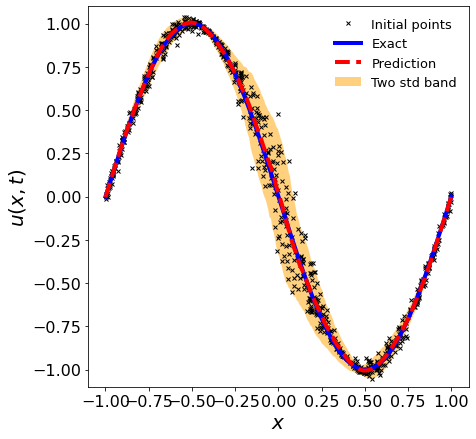

In [10]:
sol = scipy.io.loadmat("burgers_shock.mat")['usol']

data = samples[256*0:256*1,:]

X_ref = np.linspace(-1.,1.,256)[:,None]
Y_ref = sol[:,0][:,None]

# Plot the prediction with the uncertainty versus the reference solution
mu_pred = np.mean(data, axis = 1)    
Sigma_pred = np.var(data, axis = 1)

X_u1 = XTY_u[0:N_u,0][:,None] * X_std + X_mean
Y_u1 = XTY_u[0:N_u,2]

ax = plt.figure(1,figsize=(7,7))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
lower = mu_pred - 2.0*np.sqrt(Sigma_pred)
upper = mu_pred + 2.0*np.sqrt(Sigma_pred)
plt.plot(X_u1, Y_u1, 'kx', markersize = 4, label = "Initial points")
plt.fill_between(X_ref.flatten(), lower.flatten(), upper.flatten(), 
                 facecolor='orange', alpha=0.5, label="Two std band")
plt.plot(X_ref,Y_ref,'b-', label = "Exact", linewidth=4)
plt.plot(X_ref, mu_pred, 'r--', label = "Prediction", linewidth=4)
plt.xlabel('$x$',fontsize=20)
plt.ylabel('$u(x,t)$',fontsize=20)
plt.axis('square')
plt.xlim([-1.1,1.1])
plt.ylim([-1.1,1.1])
plt.legend(loc='upper right', frameon=False, prop={'size': 13})
plt.show()

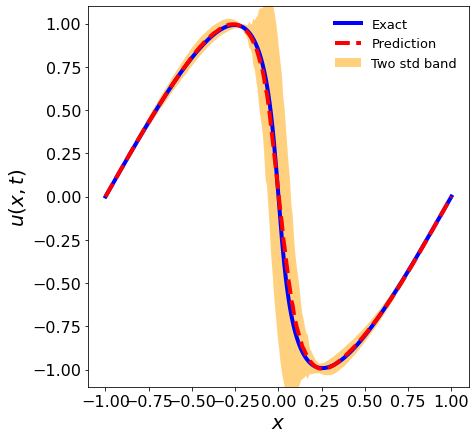

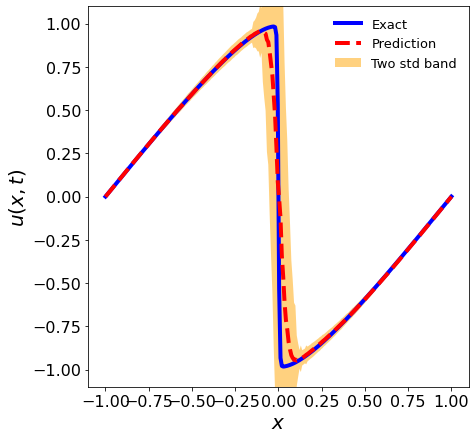

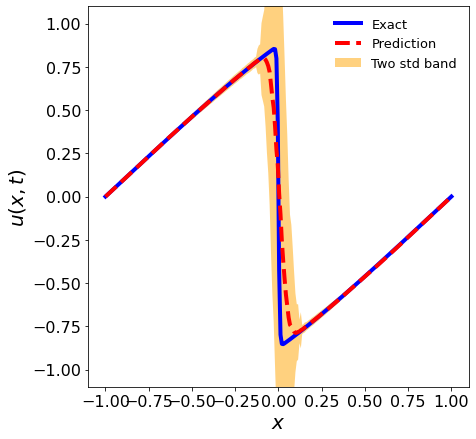

In [12]:
data = samples[256*1:256*2,:]
X_ref = np.linspace(-1.,1.,256)[:,None]
Y_ref = sol[:,25][:,None]
mu_pred = np.mean(data, axis = 1)    
Sigma_pred = np.var(data, axis = 1)
ax = plt.figure(2,figsize=(7,7))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
lower = mu_pred - 2.0*np.sqrt(Sigma_pred)
upper = mu_pred + 2.0*np.sqrt(Sigma_pred)
plt.fill_between(X_ref.flatten(), lower.flatten(), upper.flatten(), 
                 facecolor='orange', alpha=0.5, label="Two std band")
plt.plot(X_ref,Y_ref,'b-', label = "Exact", linewidth=4)
plt.plot(X_ref, mu_pred, 'r--', label = "Prediction", linewidth=4)
plt.xlabel('$x$',fontsize=20)
plt.ylabel('$u(x,t)$',fontsize=20)
plt.axis('square')
plt.xlim([-1.1,1.1])
plt.ylim([-1.1,1.1])
plt.legend(loc='upper right', frameon=False, prop={'size': 13})
plt.show()



data = samples[256*2:256*3,:]
X_ref = np.linspace(-1.,1.,256)[:,None]
Y_ref = sol[:,50][:,None]
mu_pred = np.mean(data, axis = 1)    
Sigma_pred = np.var(data, axis = 1)
ax = plt.figure(3,figsize=(7,7))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
lower = mu_pred - 2.0*np.sqrt(Sigma_pred)
upper = mu_pred + 2.0*np.sqrt(Sigma_pred)
plt.fill_between(X_ref.flatten(), lower.flatten(), upper.flatten(), 
                 facecolor='orange', alpha=0.5, label="Two std band")
plt.plot(X_ref,Y_ref,'b-', label = "Exact", linewidth=4)
plt.plot(X_ref, mu_pred, 'r--', label = "Prediction", linewidth=4)
plt.xlabel('$x$',fontsize=20)
plt.ylabel('$u(x,t)$',fontsize=20)
plt.axis('square')
plt.xlim([-1.1,1.1])
plt.ylim([-1.1,1.1])
plt.legend(loc='upper right', frameon=False, prop={'size': 13})
plt.show()



data = samples[256*3:256*4,:]
X_ref = np.linspace(-1.,1.,256)[:,None]
Y_ref = sol[:,75][:,None]
mu_pred = np.mean(data, axis = 1)    
Sigma_pred = np.var(data, axis = 1)
ax = plt.figure(4,figsize=(7,7))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
lower = mu_pred - 2.0*np.sqrt(Sigma_pred)
upper = mu_pred + 2.0*np.sqrt(Sigma_pred)
plt.fill_between(X_ref.flatten(), lower.flatten(), upper.flatten(), 
                 facecolor='orange', alpha=0.5, label="Two std band")
plt.plot(X_ref,Y_ref,'b-', label = "Exact", linewidth=4)
plt.plot(X_ref, mu_pred, 'r--', label = "Prediction", linewidth=4)
plt.xlabel('$x$',fontsize=20)
plt.ylabel('$u(x,t)$',fontsize=20)
plt.axis('square')
plt.xlim([-1.1,1.1])
plt.ylim([-1.1,1.1])
plt.legend(loc='upper right', frameon=False, prop={'size': 13})
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


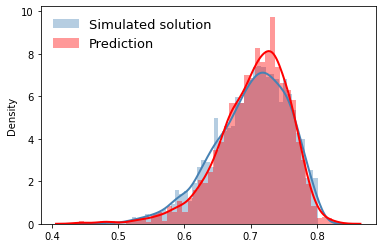

0.70493555
0.053217094
0.7010985945058651
0.056066430254589454


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


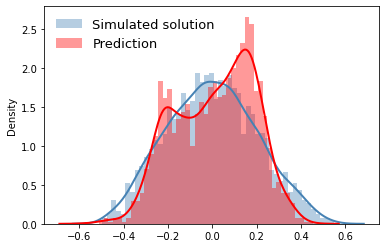

0.010980165
0.17782798
-0.001001807559158447
0.2023255332208197


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


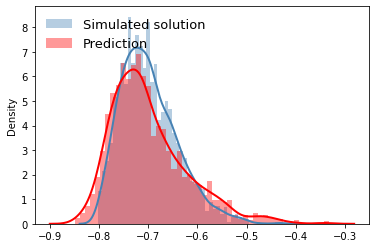

-0.69883215
0.0774597
-0.6980397971056301
0.057812315381527396


In [16]:
Y2 = np.random.normal(loc=0,scale=1,size=(1,2000))* 0.1 / np.exp(3 * np.abs(-0.25))
Y2 = -np.sin(np.pi * (-0.25+ Y2)) + Y2
data = samples[256*0+128-32,:]
Y1 = data
plt.figure()
sns.distplot(Y2, hist=True, kde=True, bins=50, color='steelblue', hist_kws={'edgecolor':'None'}, kde_kws={'linewidth':2}, label='Simulated solution')
sns.distplot(Y1, hist=True, kde=True, bins=50, color='red', hist_kws={'edgecolor':'None'}, kde_kws={'linewidth':2}, label="Prediction")
plt.legend(loc='upper left', frameon=False, prop={'size': 13})
plt.show()
print(np.mean(Y1))
print(np.std(Y1))
print(np.mean(Y2))
print(np.std(Y2))

Y2 = np.random.normal(loc=0,scale=1,size=(1,2000))* 0.1 / np.exp(3 * np.abs(0))
Y2 = -np.sin(np.pi * (0+ Y2)) + Y2
data = samples[256*0+128,:]
Y1 = data
plt.figure()
sns.distplot(Y2, hist=True, kde=True, bins=50, color='steelblue', hist_kws={'edgecolor':'None'}, kde_kws={'linewidth':2}, label='Simulated solution')
sns.distplot(Y1, hist=True, kde=True, bins=50, color='red', hist_kws={'edgecolor':'None'}, kde_kws={'linewidth':2}, label="Prediction")
plt.legend(loc='upper left', frameon=False, prop={'size': 13})
plt.show()
print(np.mean(Y1))
print(np.std(Y1))
print(np.mean(Y2))
print(np.std(Y2))

Y2 = np.random.normal(loc=0,scale=1,size=(1,2000))* 0.1 / np.exp(3 * np.abs(0.25))
Y2 = -np.sin(np.pi * (0.25+ Y2)) + Y2
data = samples[256*0+128+32,:]
Y1 = data
plt.figure()
sns.distplot(Y2, hist=True, kde=True, bins=50, color='steelblue', hist_kws={'edgecolor':'None'}, kde_kws={'linewidth':2}, label='Simulated solution')
sns.distplot(Y1, hist=True, kde=True, bins=50, color='red', hist_kws={'edgecolor':'None'}, kde_kws={'linewidth':2}, label="Prediction")
plt.legend(loc='upper left', frameon=False, prop={'size': 13})
plt.show()
print(np.mean(Y1))
print(np.std(Y1))
print(np.mean(Y2))
print(np.std(Y2))